In [ ]:
!rm -rf /content/light-transport

In [ ]:
!git clone https://github.com/dipanjan92/light-transport.git

In [ ]:
import sys
sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [ ]:
!pip install pyvista

In [1]:
import os
os.chdir('/content/light-transport/')
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/light-transport/'

In [1]:
import math
import shutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [2]:
from LightTransportSimulator.light_transport.src.scene import Scene, Light
from LightTransportSimulator.light_transport.src.primitives import Triangle, PreComputedTriangle
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_box, get_floor
from LightTransportSimulator.light_transport.src.constants import *

In [3]:
#load object
mesh = pv.Cone(radius=2, center=[0,0,0], height=5)
tri = mesh.triangulate()
points = np.ascontiguousarray(tri.points)
faces = tri.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)
len(vertices)

10

In [4]:
#set scene depths

xmax, ymax, zmax = points.max(axis=0)
xmin, ymin, zmin = points.min(axis=0)

padding = 5
depth = abs(max(xmax, ymax, zmax)) + padding
x_depth = abs(xmax) + 10
y_depth = abs(ymax) + 1
z_depth = abs(zmax) + 10
xmax, ymax, zmax, depth

(2.5, 2.0, 1.7320508, 7.5)

In [5]:
# empty object list
objects = numba.typed.List()

In [6]:
surface_color = WHITE_2
left_wall_color = RED
right_wall_color = GREEN
surface_mat = Material(color=surface_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1) # calcium sulphate
left_wall_mat = Material(color=left_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)
right_wall_mat = Material(color=right_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)

objects = get_cornell_box(depth, surface_mat, left_wall_mat, right_wall_mat)

In [7]:

for v in vertices:
    a,b,c = np.append(v[0], 1),np.append(v[1], 1),np.append(v[2], 1)

    triangle = PreComputedTriangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64),
                                   material=GLASS_MAT)
    objects.append(triangle)

objects

ListType[instance.jitclass.PreComputedTriangle#258789fa800<type:int64,vertex_1:array(float64, 1d, C),vertex_2:array(float64, 1d, C),vertex_3:array(float64, 1d, C),centroid:array(float64, 1d, C),material:instance.jitclass.Material#2587b133250<color:instance.jitclass.Color#2587b0e5d80<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflection:float64,ior:float64,is_diffuse:bool,is_mirror:bool,emission:float64,transmission:float64>,is_light:bool,edge_1:array(float64, 1d, C),edge_2:array(float64, 1d, C),normal:array(float64, 1d, C),num:float64,transformation:array(float64, 2d, A)>]([<numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x0000025877277E20>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000002587D1AE410>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x0000025877277E20>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000002587D1AE410>, <num

In [8]:
from LightTransportSimulator.light_transport.src.light_samples import generate_area_light_samples

# global light source

source_mat = Material(color=WHITE, shininess=1, reflection=0.9, ior=1.5, emission=200)


light_1 = PreComputedTriangle(vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, 1, 1], dtype=np.float64),
                              vertex_3=np.array([-1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)

light_2 = PreComputedTriangle(vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, -1, 1], dtype=np.float64),
                              vertex_3=np.array([1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)

light_sources = generate_area_light_samples(tri_1=light_1,
                                          tri_2=light_2,
                                          source_mat=source_mat,
                                          number_of_samples=1000,
                                          total_area=4)

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\intersects.py:25: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  b = 2 * np.dot(ray_direction, ray_origin - center)


In [9]:
objects.append(light_1)
objects.append(light_2)

In [10]:
# setup scene

#camera
camera = np.array([0, 0, depth+0.5, 1], dtype=np.float64)

#screen
width=300
height=300
max_depth=5

#scene
scene = Scene(camera=camera, lights=light_sources, width=width, height=height, max_depth=max_depth, f_distance=depth)

In [11]:
from LightTransportSimulator.light_transport.src.primitives import AABB
# min_point=np.array([scene.left, scene.bottom, -scene.depth], dtype=np.float64)
# max_point=np.array([scene.right, scene.top, scene.depth], dtype=np.float64)
min_point=np.array([-depth, -depth, depth], dtype=np.float64)
max_point=np.array([depth, depth, -depth], dtype=np.float64)
box = AABB(min_point=min_point, max_point=max_point)
box

In [12]:
from LightTransportSimulator.light_transport.src.bvh import BVH

bvh = BVH()
bvh.insert(objects, box)

In [13]:
from LightTransportSimulator.light_transport.src.path_tracing import render_scene

start = time.time()
image = render_scene(scene, bvh.top, number_of_samples=64)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\path_tracing.py:150: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  color += trace_path(scene, bvh, ray, 0)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\path_tracing.py:150: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  color += trace_path(scene, bvh, ray, 0)


0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.33333333333333337
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.6666666666666667
1.3333333333333335
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
2.0
1.6666666666666667
1.6666666666666667
2.0
1.6666666666666667
2.0
2.0
2.3333333333333335
2.0
2.0
2.3333333333333335
2.0
2.3333333333333335
2.0
2.666666666666667
2.3333333333333335
2.3333333333333335
2.666666666666667
2.3333333333333335
2.3333333333333335
2.666666666666667
3.0
2.666666666666667
2.3333333333333335
3.0
2.666666666666667
2.666666666666667
3.3333333333333335
3.0
2.666666666666667
3.0
3.33333

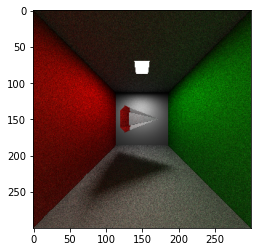

In [14]:
plt.imshow(image)